# End-to-End Credit Risk Model with Explainable AI (XAI)
## Lending Club Loan Data

**Objective:** To build and interpret a machine learning model that predicts the probability of a loan being "Charged Off" (defaulted), using data from Lending Club.

**Workflow:**
1. Project Setup & Data Ingestion (with memory management)
2. Exploratory Data Analysis (EDA) & Preprocessing
3. Feature Engineering
4. Model Building & Evaluation
5. Model Interpretation with Explainable AI (XAI)

**Step 0: Import Libraries**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc # Garbage Collection interface

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

# LightGBM
import lightgbm as lgb

# SHAP
import shap

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style

# For saving processed data
import pyarrow # Or use pyarrow for parquet


---
### **Step 1: Project Setup & Data Ingestion (with Memory Management)**
---

**Guiding Principle (Memory Management):** We will use techniques like chunking, data type downcasting, and selective feature loading.

%% [markdown]
**1.1. Define File Paths and Parameters**

* **ACTION REQUIRED:** Update `DATA_FILE_PATH` to the location of your Lending Club dataset.
* We will aim to use loans issued between 2016-2018 for this example.

In [43]:
# !!! ACTION REQUIRED: Update this path to where you saved the Lending Club data !!!
# Example: If your file is named 'accepted_2007_to_2018Q4.csv.gz' and is in a 'data' subfolder
DATA_FILE_PATH = 'accepted_2007_to_2018Q4.csv.gz' # Or 'loan.csv' or similar
# PROCESSED_DATA_PATH_PARQUET = 'data/lc_processed_2016_2018.feather'
PROCESSED_DATA_PATH_PARQUET = 'data/lc_processed_2016_2018.parquet' # Alternative

# Define years to filter for (adjust as needed)
YEARS_TO_FILTER = [2016, 2017, 2018]

# Define final loan statuses we are interested in
FINAL_LOAN_STATUSES = ['Fully Paid', 'Charged Off']

**1.2. Initial Data Exploration (Header and Chunking Strategy)**

First, let's peek at the columns without loading the whole file.

In [44]:
# To peek at columns if you're unsure (run this once if needed)
try:
    print("Peeking at columns:")
    df_peek = pd.read_csv(DATA_FILE_PATH, nrows=5, compression='gzip' if DATA_FILE_PATH.endswith('.gz') else None)
    print(df_peek.info())
    del df_peek
    gc.collect()
except FileNotFoundError:
    print(f"ERROR: Data file not found at {DATA_FILE_PATH}. Please update the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Peeking at columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Columns: 151 entries, id to settlement_term
dtypes: float64(125), int64(1), object(25)
memory usage: 6.0+ KB
None


**1.3. Memory-Efficient Loading and Filtering**

We'll load the data in chunks, filter rows and columns within each chunk, and then concatenate.

In [45]:
def load_and_filter_lending_club_data(file_path, chunk_size=50000, years_to_filter=None, final_statuses=None):
    """
    Loads Lending Club data in chunks, filters by year and loan status,
    and selects potentially useful columns to save memory.
    """
    if years_to_filter is None:
        years_to_filter = []
    if final_statuses is None:
        final_statuses = []

    print(f"Starting to load and filter data from: {file_path}")
    
    # Pre-identify columns to keep. This list is based on common knowledge of LC data
    # and aims to exclude obvious data leakage, IDs, and highly sparse columns.
    # This list may need adjustment based on the exact version of the LC dataset.
    # We will refine this further after initial load.
    potential_cols_to_keep = [
        'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
        'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
        'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
        'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
        'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
        'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
        'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'application_type',
        'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq',
        'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m',
        'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
        'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
        'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
        'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
        'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
        'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
        'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
        'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
        'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
        'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
        'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
        'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
        'hardship_flag', # Added hardship_flag
        # Potentially target leakage columns if not handled carefully, or post-origination:
        # 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 
        # 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 
        # 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
        # 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low'
    ]

    # Date parsing for issue_d to filter by year
    date_parser_func = lambda x: pd.to_datetime(x, format='%b-%Y', errors='coerce')

    chunks = []
    try:
        iterator = pd.read_csv(
            file_path,
            chunksize=chunk_size,
            usecols=lambda col: col in potential_cols_to_keep or col == 'issue_d', # Ensure issue_d is loaded for filtering
            parse_dates=['issue_d'], # Parse issue_d directly if possible
            date_parser=date_parser_func, # Conditional date_parser
            compression='gzip' if file_path.endswith('.gz') else None,
            low_memory=False # Suppress DtypeWarning, we'll handle types later
        )

        for i, chunk in enumerate(iterator):
            print(f"Processing chunk {i+1}...")
            
            # Ensure 'issue_d' is datetime
            if 'issue_d' in chunk.columns and not pd.api.types.is_datetime64_any_dtype(chunk['issue_d']):
                 chunk['issue_d'] = pd.to_datetime(chunk['issue_d'], errors='coerce') # format='%b-%Y'

            # Filter by year
            if years_to_filter and 'issue_d' in chunk.columns:
                chunk = chunk[chunk['issue_d'].dt.year.isin(years_to_filter)]
            
            # Filter by loan status
            if final_statuses and 'loan_status' in chunk.columns:
                chunk = chunk[chunk['loan_status'].isin(final_statuses)]
            
            if not chunk.empty:
                chunks.append(chunk)
            
            gc.collect() # Collect garbage after processing each chunk

    except FileNotFoundError:
        print(f"ERROR: Data file not found at {file_path}. Please update the path.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred during chunk processing: {e}")
        return pd.DataFrame()

    if not chunks:
        print("No data found matching the criteria.")
        return pd.DataFrame()

    print("Concatenating chunks...")
    df_filtered = pd.concat(chunks, ignore_index=True)
    print(f"Filtered data shape: {df_filtered.shape}")
    
    # Select only the predefined potential columns that actually exist in the loaded data
    existing_cols = [col for col in potential_cols_to_keep if col in df_filtered.columns]
    # Ensure 'issue_d' and 'loan_status' are definitely included if they exist in df_filtered, then remove duplicates
    final_cols_to_select = list(set(existing_cols + ['issue_d', 'loan_status']))
    final_cols_to_select = [col for col in final_cols_to_select if col in df_filtered.columns] # Keep only existing
    
    df_filtered = df_filtered[final_cols_to_select]
    # df_filtered = df_filtered.loc[:, ~df_filtered.columns.duplicated()] # Should not be needed if final_cols_to_select is from a set
    
    print(f"Shape after selecting existing potential columns: {df_filtered.shape}")
    
    return df_filtered

# Load the data
df = load_and_filter_lending_club_data(DATA_FILE_PATH, 
                                       years_to_filter=YEARS_TO_FILTER, 
                                       final_statuses=FINAL_LOAN_STATUSES)

# %%
if not df.empty:
    print("Initial loaded and filtered data info:")
    df.info(verbose=True, show_counts=True, memory_usage='deep')
else:
    print("DataFrame is empty. Cannot proceed with data type downcasting or saving.")
    # Potentially raise an error or exit if df is critical for next steps
    # For this notebook, we'll allow it to continue so subsequent cells don't auto-fail on run-all
    # but in a real script, you'd handle this more strictly.


Starting to load and filter data from: accepted_2007_to_2018Q4.csv.gz
Processing chunk 1...
Processing chunk 2...
Processing chunk 3...
Processing chunk 4...
Processing chunk 5...
Processing chunk 6...
Processing chunk 7...
Processing chunk 8...
Processing chunk 9...
Processing chunk 10...
Processing chunk 11...
Processing chunk 12...
Processing chunk 13...
Processing chunk 14...
Processing chunk 15...
Processing chunk 16...
Processing chunk 17...
Processing chunk 18...
Processing chunk 19...
Processing chunk 20...
Processing chunk 21...
Processing chunk 22...
Processing chunk 23...
Processing chunk 24...
Processing chunk 25...
Processing chunk 26...
Processing chunk 27...
Processing chunk 28...
Processing chunk 29...
Processing chunk 30...
Processing chunk 31...
Processing chunk 32...
Processing chunk 33...
Processing chunk 34...
Processing chunk 35...
Processing chunk 36...
Processing chunk 37...
Processing chunk 38...
Processing chunk 39...
Processing chunk 40...
Processing chunk 41

**1.4. Data Type Downcasting**

Helper function to downcast numerical data types to save memory.


In [46]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    # Note: float16 has precision issues, float32 is often preferred
                    df[col] = df[col].astype(np.float32) # Using float32 instead of float16
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Optionally convert object columns with low cardinality to category
        # elif col_type == 'object':
        #     if len(df[col].unique()) / len(df[col]) < 0.05: # Stricter threshold for category conversion
        #         df[col] = df[col].astype('category')
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

if not df.empty:
    df = reduce_mem_usage(df)
    print("\nData info after memory reduction:")
    df.info(verbose=True, show_counts=True, memory_usage='deep')
else:
    print("DataFrame is empty. Skipping memory reduction.")


Memory usage reduced from 859.09 MB to 708.71 MB (17.5% reduction)

Data info after memory reduction:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518706 entries, 0 to 518705
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   mo_sin_old_il_acct              505010 non-null  float32       
 1   fico_range_high                 518706 non-null  float32       
 2   emp_length                      482772 non-null  object        
 3   avg_cur_bal                     518696 non-null  float32       
 4   num_tl_120dpd_2m                494386 non-null  float32       
 5   loan_amnt                       518706 non-null  float32       
 6   num_bc_tl                       518706 non-null  float32       
 7   mths_since_recent_bc_dlq        125764 non-null  float32       
 8   il_util                         448556 non-null  float32       
 9   purpose                

**1.5. Save Processed Data**

Save the cleaned, memory-optimized DataFrame for faster loading in future sessions.


In [47]:
import os
if not df.empty:
    # Ensure 'data' directory exists
    if not os.path.exists('data'):
        os.makedirs('data')
        
    print(f"\nSaving processed data to Feather format: {PROCESSED_DATA_PATH_PARQUET}")
    try:
        df.reset_index(drop=True).to_feather(PROCESSED_DATA_PATH_PARQUET)
        print("Successfully saved to Feather.")
    except Exception as e:
        print(f"Error saving to Feather: {e}")
        print(f"Attempting to save to Parquet format: {PROCESSED_DATA_PATH_PARQUET}")
        try:
            df.to_parquet(PROCESSED_DATA_PATH_PARQUET, index=False)
            print("Successfully saved to Parquet.")
        except Exception as e_parquet:
            print(f"Error saving to Parquet: {e_parquet}")

    # Optional: Delete the DataFrame and collect garbage if memory is extremely tight
    # del df
    # gc.collect()
    # print("DataFrame deleted from memory to save space.")
else:
    print("DataFrame is empty. Skipping saving processed data.")



Saving processed data to Feather format: data/lc_processed_2016_2018.parquet
Successfully saved to Feather.


---
### **Step 2: Exploratory Data Analysis (EDA) & Preprocessing**
---

If you saved the processed data, you can load it directly here to skip Step 1 in future runs.

In [48]:
# To load processed data in future sessions:
LOAD_PROCESSED = True # Set to True to try loading, False to re-run Step 1

df_loaded = pd.DataFrame() # Initialize an empty DataFrame

if LOAD_PROCESSED:
    try:
        print(f"Attempting to load processed data from Feather: {PROCESSED_DATA_PATH_PARQUET}")
        df_loaded = pd.read_feather(PROCESSED_DATA_PATH_PARQUET)
        print(f"Successfully loaded from Feather. Shape: {df_loaded.shape}")
    except Exception as e_feather:
        print(f"Could not load from Feather: {e_feather}")
        try:
            print(f"Attempting to load processed data from Parquet: {PROCESSED_DATA_PATH_PARQUET}")
            df_loaded = pd.read_parquet(PROCESSED_DATA_PATH_PARQUET)
            print(f"Successfully loaded from Parquet. Shape: {df_loaded.shape}")
        except Exception as e_parquet:
            print(f"Could not load from Parquet: {e_parquet}. \nMake sure Step 1 was run successfully or set LOAD_PROCESSED = False.")

if df_loaded.empty and df.empty: # If neither loaded nor processed df exists
     print("CRITICAL ERROR: No data available. Exiting EDA. Please ensure Step 1 runs correctly or a processed file exists.")
elif not df_loaded.empty:
    df = df_loaded # Use the loaded data
    print("Using pre-processed data for EDA.")
    df.info(verbose=True, show_counts=True, memory_usage='deep')
elif df.empty: # This case should ideally not be hit if checks in Step 1 are robust
    print("CRITICAL ERROR: Initial DataFrame 'df' is empty and no processed data loaded. Cannot proceed with EDA.")
else: # df from Step 1 exists but df_loaded is empty (e.g. first run)
    print("Using data processed in Step 1 for EDA.")


gc.collect()

Attempting to load processed data from Feather: data/lc_processed_2016_2018.parquet
Successfully loaded from Feather. Shape: (518706, 95)
Using pre-processed data for EDA.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518706 entries, 0 to 518705
Data columns (total 95 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   mo_sin_old_il_acct              505010 non-null  float32       
 1   fico_range_high                 518706 non-null  float32       
 2   emp_length                      482772 non-null  object        
 3   avg_cur_bal                     518696 non-null  float32       
 4   num_tl_120dpd_2m                494386 non-null  float32       
 5   loan_amnt                       518706 non-null  float32       
 6   num_bc_tl                       518706 non-null  float32       
 7   mths_since_recent_bc_dlq        125764 non-null  float32       
 8   il_util               

19

**2.1. Define Target Variable**

In [49]:
if not df.empty and 'loan_status' in df.columns:
    df['target'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
    print("\nTarget variable distribution:")
    print(df['target'].value_counts(normalize=True))
else:
    print("DataFrame is empty or 'loan_status' column is missing. Cannot define target variable.")


Target variable distribution:
0    0.775871
1    0.224129
Name: target, dtype: float64


**2.2. Analyze Class Imbalance**

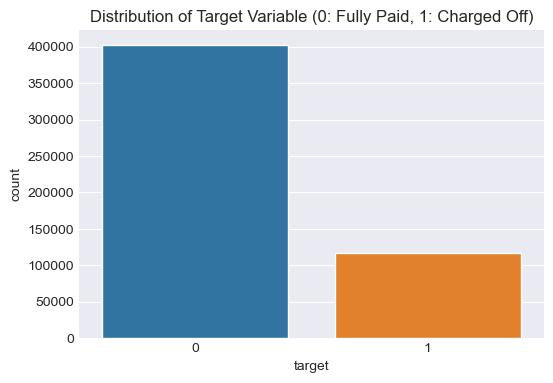

Imbalance ratio (Class 0 / Class 1): 3.46


In [50]:

if not df.empty and 'target' in df.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=df)
    plt.title('Distribution of Target Variable (0: Fully Paid, 1: Charged Off)')
    plt.show()
    
    # Store imbalance ratio for later use if needed (e.g. for SMOTE or class weights)
    target_counts = df['target'].value_counts()
    imbalance_ratio = target_counts.get(0, 0) / target_counts.get(1, 1) if target_counts.get(1,1) > 0 else float('inf')
    print(f"Imbalance ratio (Class 0 / Class 1): {imbalance_ratio:.2f}")
else:
    print("DataFrame is empty or 'target' column is missing. Cannot plot class imbalance.")


**2.3. Data Cleaning and Preprocessing (Continued)**

* Identify columns with high percentage of missing values.
* Handle date columns.
* Clean or standardize specific columns like `emp_length`, `term`, `revol_util`.

In [51]:
if not df.empty:
    # Calculate missing value percentages
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
    missing_df = missing_df[missing_df['Percentage'] > 0].sort_values(by='Percentage', ascending=False)
    print("\nColumns with missing values (%):")
    print(missing_df.head(20)) # Display top 20

    # Drop columns with very high percentage of missing values (e.g., > 70%)
    # This threshold can be adjusted.
    cols_to_drop_due_to_na = missing_df[missing_df['Percentage'] > 70].index.tolist()
    # Add other known problematic or irrelevant columns (e.g., free text, IDs already handled)
    cols_to_drop_manual = ['emp_title', 'title', 'zip_code'] # issue_d is handled below, kept for credit_history
                                                                    # emp_title, title are free text, hard to use directly
                                                                    # zip_code is too granular, addr_state is better
    
    all_cols_to_drop = list(set(cols_to_drop_due_to_na + cols_to_drop_manual))
    # Ensure target and loan_status are not dropped if they were accidentally added
    all_cols_to_drop = [col for col in all_cols_to_drop if col not in ['target', 'loan_status', 'issue_d', 'earliest_cr_line']]


    df.drop(columns=all_cols_to_drop, inplace=True, errors='ignore')
    print(f"\nDropped columns due to high NA or manual selection: {all_cols_to_drop}")
    print(f"Shape after dropping high NA columns: {df.shape}")
    gc.collect()

    # --- Date Feature Engineering ---
    # 'earliest_cr_line' and 'issue_d': Convert to datetime and calculate credit history length
    # Ensure 'issue_d' is datetime (it should be from loading step, but double check)
    if 'issue_d' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['issue_d']):
        df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')

    if 'earliest_cr_line' in df.columns and 'issue_d' in df.columns:
        df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
        
        # Calculate credit history length in years at the time of loan issuance
        # Ensure both dates are valid before subtraction
        mask_valid_dates = df['issue_d'].notna() & df['earliest_cr_line_date'].notna()
        df.loc[mask_valid_dates, 'credit_history_length_years'] = \
            (df.loc[mask_valid_dates, 'issue_d'] - df.loc[mask_valid_dates, 'earliest_cr_line_date']).dt.days / 365.25
        
        df.drop(columns=['earliest_cr_line', 'earliest_cr_line_date'], inplace=True, errors='ignore')
        print("Engineered 'credit_history_length_years'.")
    
    # Now that 'issue_d' has been used for feature engineering, it can be dropped
    if 'issue_d' in df.columns:
        df.drop(columns=['issue_d'], inplace=True, errors='ignore')
        print("Dropped 'issue_d' after feature engineering.")


    # --- Clean specific string/object columns ---
    # 'emp_length': Convert to numerical
    if 'emp_length' in df.columns:
        emp_length_mapping = {
            '< 1 year': 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
            '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
            '10+ years': 10
        }
        df['emp_length_num'] = df['emp_length'].map(emp_length_mapping)
        df.drop(columns=['emp_length'], inplace=True, errors='ignore')
        print("Cleaned 'emp_length'.")

    # 'term': Clean and convert to numeric
    if 'term' in df.columns:
        df['term_num'] = df['term'].str.extract('(\\d+)').astype(float) # Extract digits
        df.drop(columns=['term'], inplace=True, errors='ignore')
        print("Cleaned 'term'.")

    # 'revol_util': Clean '%' and convert to numeric
    if 'revol_util' in df.columns:
        df['revol_util_num'] = df['revol_util'].astype(str).str.rstrip('%').astype(float) / 100.0
        df.drop(columns=['revol_util'], inplace=True, errors='ignore')
        print("Cleaned 'revol_util'.")
        
    # FICO scores: Use the lower bound or average. Let's use lower bound.
    if 'fico_range_low' in df.columns and 'fico_range_high' in df.columns:
        df['fico_score'] = df['fico_range_low'] # Or (df['fico_range_low'] + df['fico_range_high']) / 2
        df.drop(columns=['fico_range_low', 'fico_range_high'], inplace=True, errors='ignore')
        print("Processed FICO scores.")

    print(f"\nShape after initial cleaning and feature tweaks: {df.shape}")
    df.info(verbose=True, show_counts=True, memory_usage='deep')
    gc.collect()

else:
    print("DataFrame is empty. Skipping EDA & Preprocessing steps.")


Columns with missing values (%):
                                Missing Values  Percentage
verification_status_joint               493512   95.142913
dti_joint                               493309   95.103777
annual_inc_joint                        493307   95.103392
mths_since_last_record                  418817   80.742656
mths_since_recent_bc_dlq                392942   75.754281
mths_since_last_major_derog             372235   71.762231
mths_since_recent_revol_delinq          339400   65.432056
mths_since_last_delinq                  254454   49.055534
il_util                                  70150   13.524039
mths_since_recent_inq                    47481    9.153740
emp_title                                36722    7.079540
emp_length                               35934    6.927624
num_tl_120dpd_2m                         24320    4.688590
title                                    16523    3.185427
mths_since_rcnt_il                       13744    2.649671
mo_sin_old_il_acct    

**2.4. Univariate & Bivariate Analysis (Examples)**

Let's plot distributions for a few key numerical features and their relationship with the target.

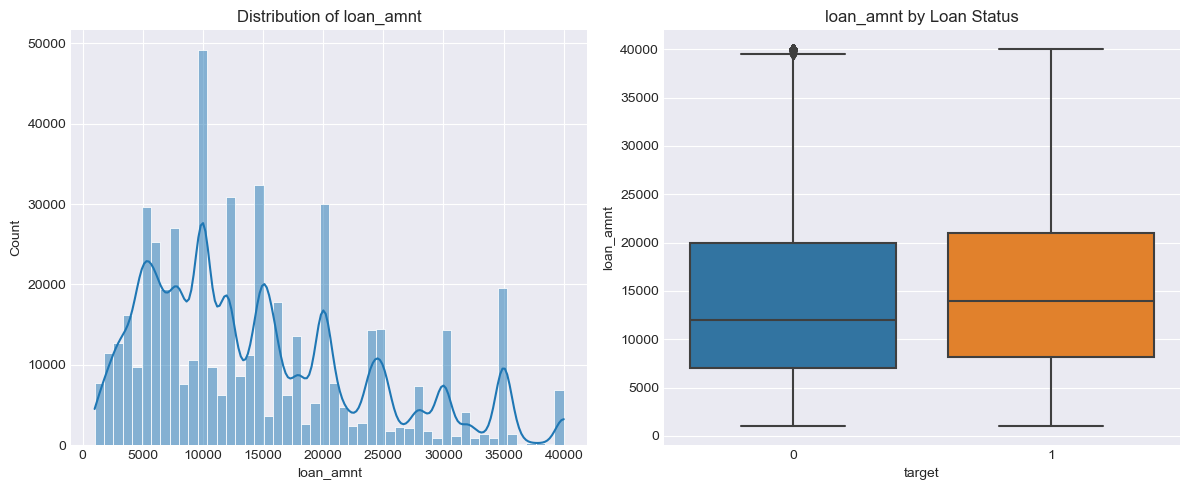

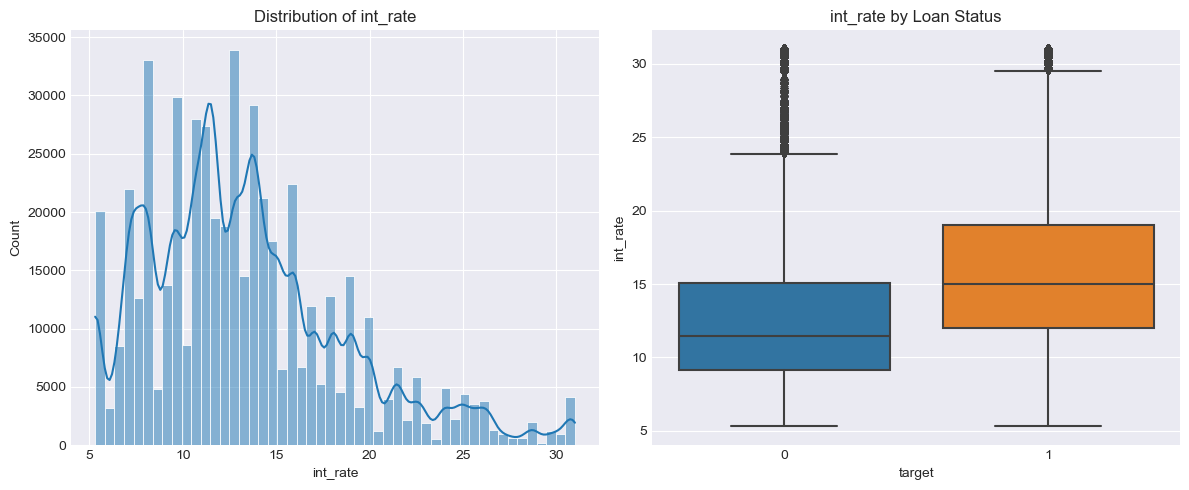

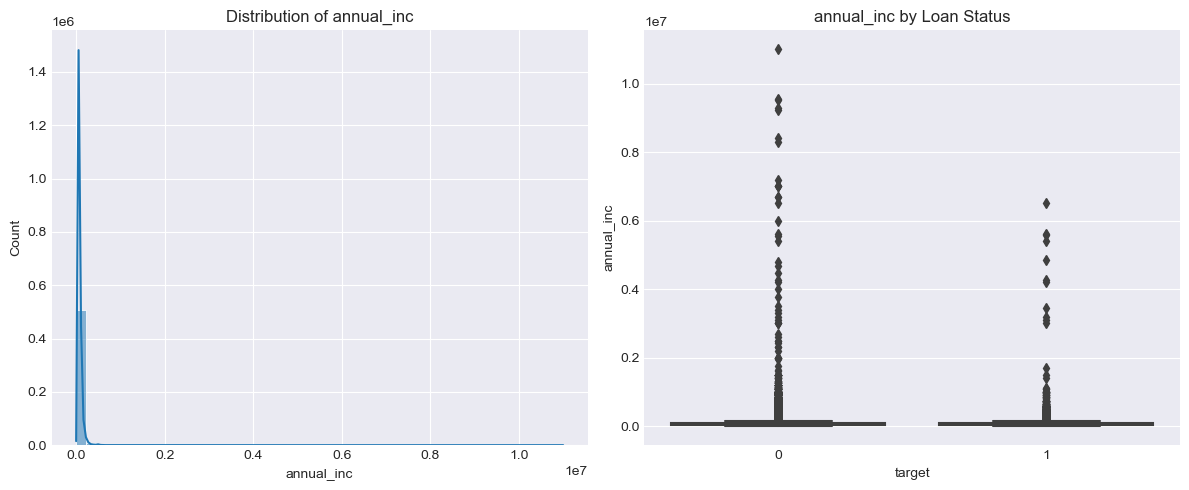

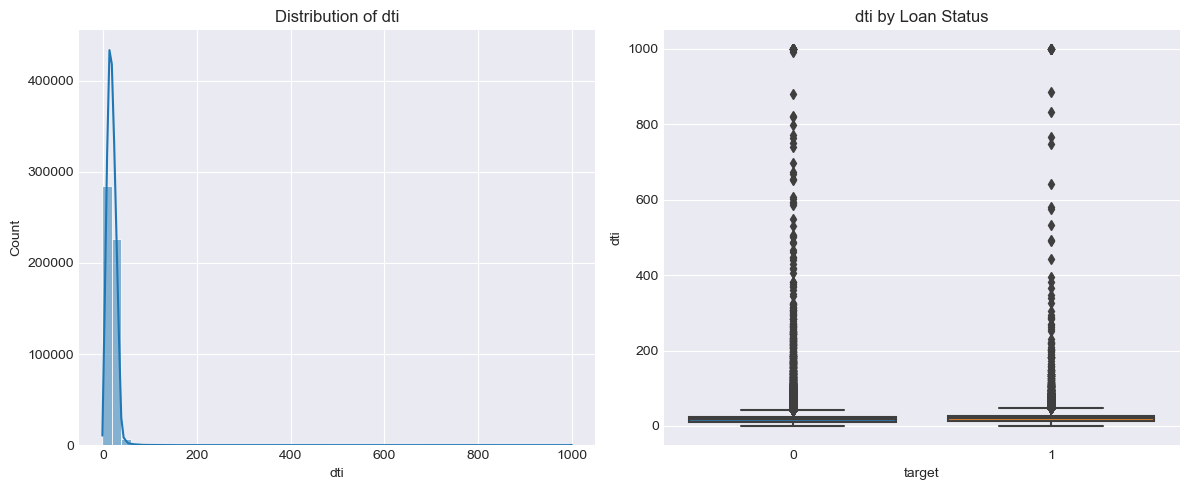

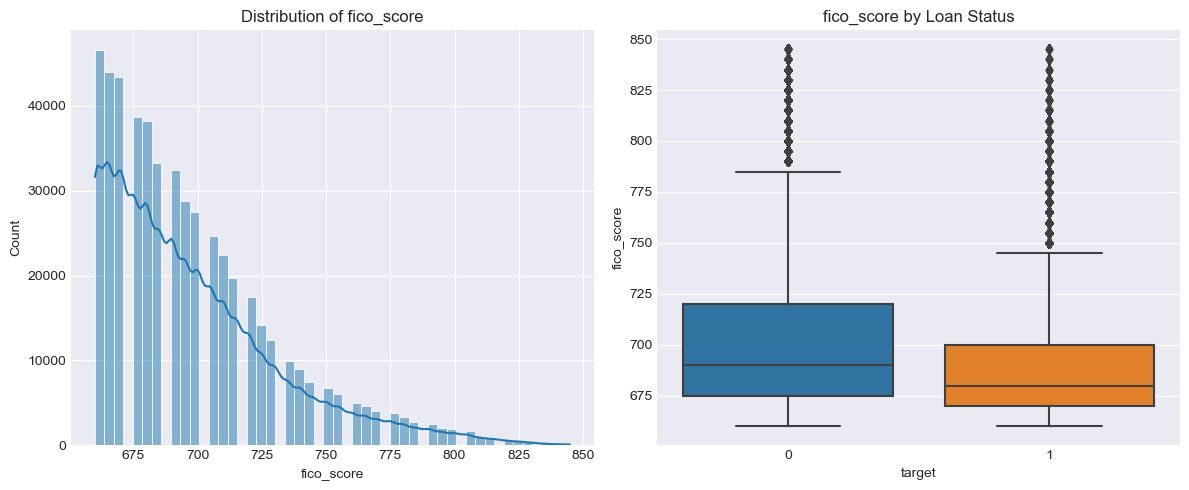

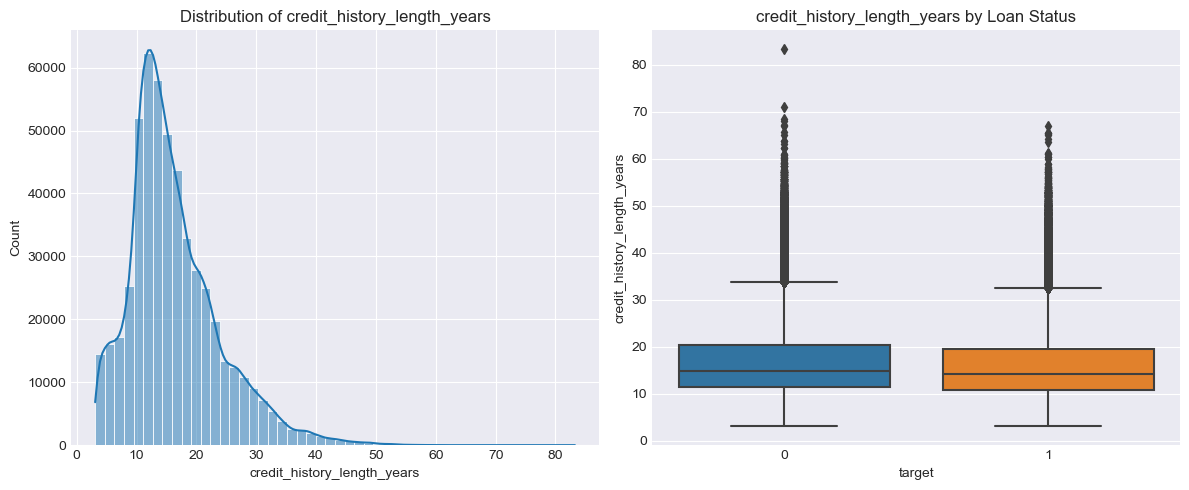

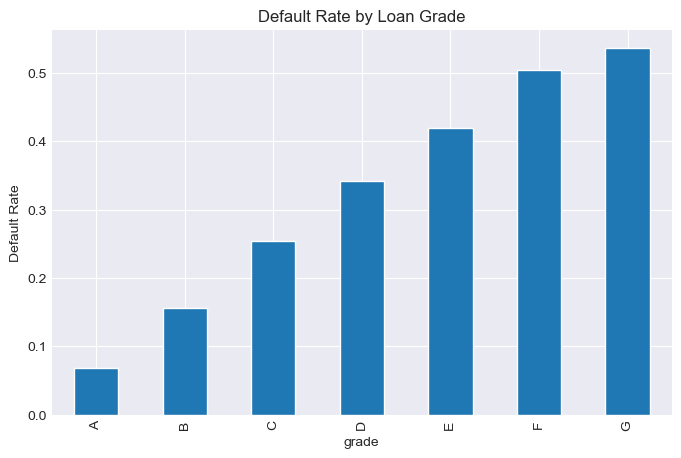

In [52]:
if not df.empty and 'target' in df.columns:
    numerical_cols_for_eda = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_score', 'credit_history_length_years']
    numerical_cols_for_eda = [col for col in numerical_cols_for_eda if col in df.columns] # Keep only existing

    for col in numerical_cols_for_eda:
        if col in df.columns: # Check again if column exists after all processing
            plt.figure(figsize=(12, 5))
            
            plt.subplot(1, 2, 1)
            sns.histplot(df[col].dropna(), kde=True, bins=50) # Drop NA for plotting robustness
            plt.title(f'Distribution of {col}')
            
            plt.subplot(1, 2, 2)
            # Ensure no NaNs in the y-axis data for boxplot
            temp_df_for_plot = df[['target', col]].dropna(subset=[col])
            sns.boxplot(x='target', y=col, data=temp_df_for_plot)
            plt.title(f'{col} by Loan Status')
            
            plt.tight_layout()
            plt.show()
        
    # Example: Default rate by 'grade'
    if 'grade' in df.columns:
        grade_default_rate = df.groupby('grade')['target'].mean().sort_values()
        plt.figure(figsize=(8, 5))
        grade_default_rate.plot(kind='bar')
        plt.title('Default Rate by Loan Grade')
        plt.ylabel('Default Rate')
        plt.show()
else:
    print("DataFrame empty or target missing. Skipping EDA plots.")

---
### **Step 3: Feature Engineering (Continued) & Final Preprocessing**
---

* Impute remaining missing values.
* Encode categorical features.

In [53]:
if not df.empty and 'target' in df.columns and df['target'].notna().all(): # Added check for NaNs in target
    # Separate features (X) and target (y)
    X = df.drop(columns=['loan_status', 'target'], errors='ignore')
    y = df['target'] 

    if y is None or y.isna().any(): # Check if y is None or contains NaNs
        print("Target variable not found or contains NaNs. Cannot proceed with feature engineering for modeling.")
        X, y = pd.DataFrame(), pd.Series() # Reset to empty
        numerical_cols, categorical_cols = [],[]
    else:
        # Identify numerical and categorical columns
        numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist() 

        print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")
        print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
        
        current_missing_X = X.isnull().sum()
        current_missing_X_pct = (current_missing_X / len(X)) * 100
        current_missing_X_df = pd.DataFrame({'Missing Count': current_missing_X, 'Percentage': current_missing_X_pct})
        current_missing_X_df = current_missing_X_df[current_missing_X_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
        print("\nMissing values in features X before pipeline imputation:")
        print(current_missing_X_df.head(20))
        
        # del df # Free up memory
        # gc.collect()
elif df.empty:
    print("DataFrame is empty. Skipping Feature Engineering steps.")
    X, y = pd.DataFrame(), pd.Series() 
    numerical_cols, categorical_cols = [],[]
else:
    print("Target column is missing or contains NaNs. Skipping Feature Engineering.")
    X, y = pd.DataFrame(), pd.Series() 
    numerical_cols, categorical_cols = [],[]


Numerical columns (73): ['mo_sin_old_il_acct', 'avg_cur_bal', 'num_tl_120dpd_2m', 'loan_amnt', 'num_bc_tl', 'il_util', 'mo_sin_rcnt_tl', 'num_accts_ever_120_pd', 'mths_since_rcnt_il', 'acc_open_past_24mths', 'inq_last_12m', 'mo_sin_rcnt_rev_tl_op', 'mths_since_last_delinq', 'tot_hi_cred_lim', 'num_sats', 'max_bal_bc', 'inq_last_6mths', 'bc_util', 'open_acc', 'revol_bal', 'annual_inc', 'pub_rec_bankruptcies', 'num_tl_30dpd', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_tl_op_past_12m', 'mort_acc', 'delinq_amnt', 'open_rv_12m', 'mths_since_recent_bc', 'delinq_2yrs', 'acc_now_delinq', 'open_il_12m', 'dti', 'num_bc_sats', 'num_rev_accts', 'bc_open_to_buy', 'funded_amnt', 'total_acc', 'open_rv_24m', 'tax_liens', 'total_bal_ex_mort', 'total_bal_il', 'pct_tl_nvr_dlq', 'mths_since_recent_revol_delinq', 'percent_bc_gt_75', 'total_il_high_credit_limit', 'installment', 'total_cu_tl', 'int_rate', 'inq_fi', 'num_op_rev_tl', 'tot_cur_bal', 'all_util', 'tot_coll_amt', 'collections_12_mths_ex_med',

---
### **Step 4: Model Building & Evaluation**
---

In [54]:
if not X.empty and not y.empty:
    # **4.1. Data Splitting**
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")
    
    del X # Free up memory
    # del y # y is needed for stratify in CV
    gc.collect()

    # Define preprocessing pipelines
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ], remainder='passthrough' 
    )
    
    print("\nFitting preprocessor on X_train...")
    X_train_processed = preprocessor.fit_transform(X_train)
    print("Transforming X_test...")
    X_test_processed = preprocessor.transform(X_test)
    
    try:
        # Try to get feature names after one-hot encoding
        ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
        feature_names_out = numerical_cols + list(ohe_feature_names)
        
        # Handle remainder columns if any feature names were generated for them
        # This part needs to be more robust if 'passthrough' actually passes columns
        # For now, assuming passthrough columns are not generating new names via get_feature_names_out on preprocessor
        num_expected_cols = len(numerical_cols) + len(ohe_feature_names)
        if X_train_processed.shape[1] > num_expected_cols:
            num_remainder_cols = X_train_processed.shape[1] - num_expected_cols
            remainder_cols_names = [f"remainder__{i}" for i in range(num_remainder_cols)] # Placeholder names
            # Potentially try to get actual names if preprocessor.feature_names_in_ is available and remainder is list of names
            # feature_names_out.extend(remainder_cols_names) # This line might be incorrect if passthrough columns aren't last
            print(f"Warning: {num_remainder_cols} columns from 'remainder=passthrough' might not have explicit names assigned. Current names count: {len(feature_names_out)}, processed shape: {X_train_processed.shape[1]}")


    except AttributeError: 
        print("Warning: Could not automatically get feature names from preprocessor. Using generic names for OHE features.")
        feature_names_out = list(numerical_cols)
        # Estimate number of OHE features (this is a rough guess and might be incorrect)
        num_ohe_features = X_train_processed.shape[1] - len(numerical_cols)
        feature_names_out.extend([f"cat_col_{i}" for i in range(num_ohe_features)])
    
    # Ensure feature_names_out matches the number of columns in X_train_processed
    if len(feature_names_out) != X_train_processed.shape[1]:
        print(f"Critical Warning: Mismatch between length of feature_names_out ({len(feature_names_out)}) and number of columns in processed data ({X_train_processed.shape[1]}). SHAP plots might be misleading or fail.")
        # Fallback to generic feature names if mismatch
        feature_names_out = [f"feature_{i}" for i in range(X_train_processed.shape[1])]


    print(f"X_train_processed shape: {X_train_processed.shape}")
    print(f"X_test_processed shape: {X_test_processed.shape}")
    
else:
    print("X or y is empty. Skipping Model Building steps.")
    X_train_processed, X_test_processed, y_train, y_test = None, None, None, None
    feature_names_out = []

X_train shape: (414964, 83), X_test shape: (103742, 83)
y_train distribution:
0    0.775872
1    0.224128
Name: target, dtype: float64
y_test distribution:
0    0.775867
1    0.224133
Name: target, dtype: float64

Fitting preprocessor on X_train...
Transforming X_test...
X_train_processed shape: (414964, 192)
X_test_processed shape: (103742, 192)


**4.2. Baseline Model: Logistic Regression**


Training Logistic Regression model...
Logistic Regression ROC AUC: 0.7190


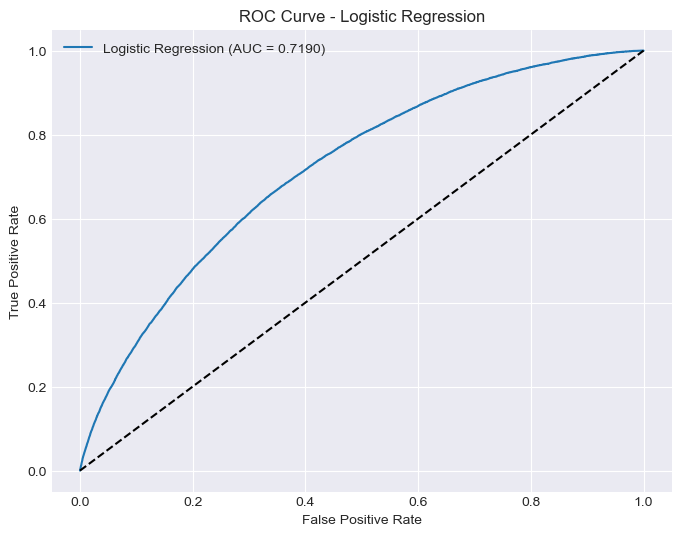

In [55]:
if X_train_processed is not None and y_train is not None and y_test is not None:
    print("\nTraining Logistic Regression model...")
    log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced') 
    log_reg.fit(X_train_processed, y_train)

    y_pred_log_reg_proba = log_reg.predict_proba(X_test_processed)[:, 1]
    roc_auc_log_reg = roc_auc_score(y_test, y_pred_log_reg_proba)
    print(f"Logistic Regression ROC AUC: {roc_auc_log_reg:.4f}")

    fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend()
    plt.show()
else:
    print("Processed training/test data or target variable not available. Skipping Logistic Regression.")

**4.3. Advanced Model: LightGBM with Hyperparameter Tuning**


Training LightGBM model with Hyperparameter Tuning...
Starting GridSearchCV for LightGBM...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 93005, number of negative: 321959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9240
[LightGBM] [Info] Number of data points in the train set: 414964, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.224128 -> initscore=-1.241771
[LightGBM] [Info] Start training from score -1.241771

GridSearchCV Best Parameters:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.7}
GridSearchCV Best ROC AUC score: 0.7330

LightGBM (Tuned) ROC AUC on Test Set: 0.7351

LightGBM (Tuned) Classification Report (0.5 th

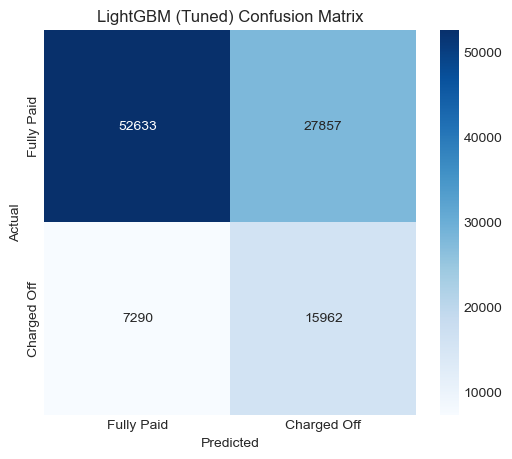

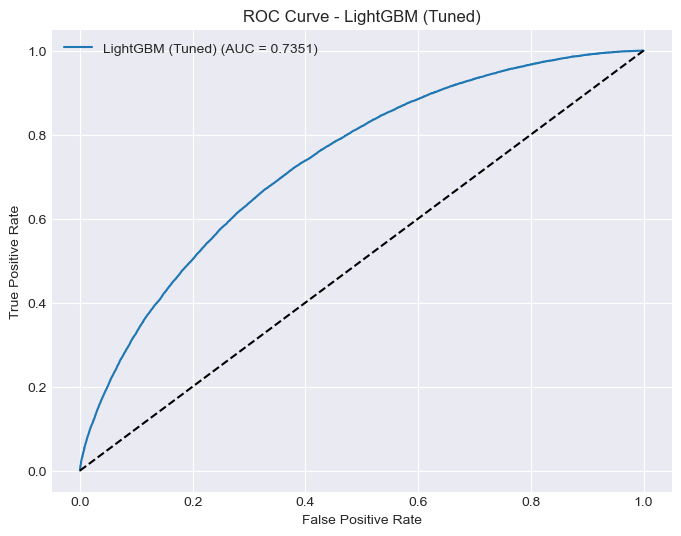

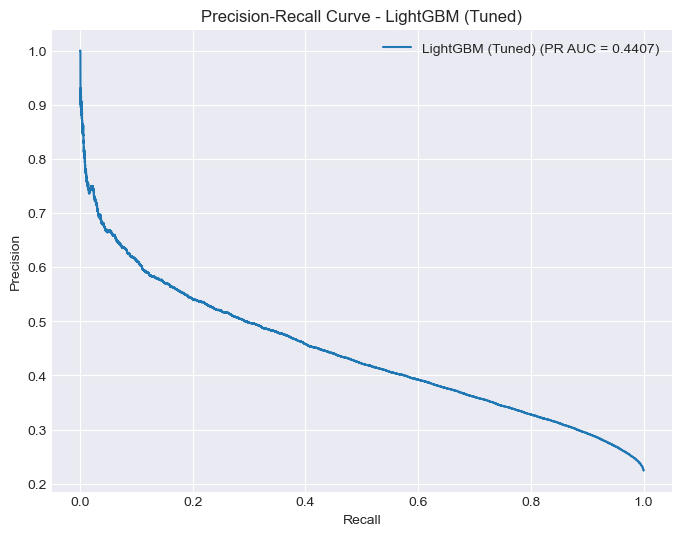

In [56]:
if X_train_processed is not None and y_train is not None and y_test is not None:
    print("\nTraining LightGBM model with Hyperparameter Tuning...")
    
    # Calculate scale_pos_weight for imbalanced data
    train_target_counts = y_train.value_counts()
    scale_pos_weight_val = train_target_counts.get(0,0) / train_target_counts.get(1,1) if train_target_counts.get(1,1) > 0 else 1

    # Define the parameter grid for GridSearchCV
    # Keep this grid small for faster execution in a portfolio project.
    # For a real-world scenario, you'd explore a wider range.
    param_grid = {
        'n_estimators': [100, 200], # Reduced for speed
        'learning_rate': [0.05, 0.1],
        'num_leaves': [20, 31], # Typical values
        'colsample_bytree': [0.7, 0.8],
        'subsample': [0.7, 0.8],
        # 'reg_alpha': [0.1, 0.5], # L1 regularization
        # 'reg_lambda': [0.1, 0.5] # L2 regularization
    }

    # Initialize LGBMClassifier
    # We pass scale_pos_weight here if it's a fixed best guess, or it can be part of param_grid too.
    lgbm_estimator = lgb.LGBMClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight_val, # Using pre-calculated based on training set
        n_jobs=-1
    )

    # Setup Stratified K-Fold cross-validator
    # StratifiedKFold is important for imbalanced datasets.
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for speed

    # Setup GridSearchCV
    # Scoring metric: 'roc_auc' is good for imbalanced classification
    grid_search = GridSearchCV(
        estimator=lgbm_estimator,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=1, # Set to 2 for more detailed output
        n_jobs=-1 # Use all available cores for grid search
    )

    print("Starting GridSearchCV for LightGBM...")
    # Fit GridSearchCV
    # Pass feature names if they are correctly aligned with X_train_processed
    fit_params = {}
    if feature_names_out and len(feature_names_out) == X_train_processed.shape[1]:
        fit_params['feature_name'] = feature_names_out
        fit_params['categorical_feature'] = [] # Assuming all categorical are OHE and thus numerical for LGBM
                                               # Or pass indices of true categorical features if not OHE'd
                                               # and if LightGBM should handle them internally.
                                               # With scikit-learn API, OHE is common before LGBM.

    grid_search.fit(X_train_processed, y_train, **fit_params)

    print("\nGridSearchCV Best Parameters:")
    print(grid_search.best_params_)
    print(f"GridSearchCV Best ROC AUC score: {grid_search.best_score_:.4f}")

    # Get the best estimator
    best_lgbm = grid_search.best_estimator_
    lgbm = best_lgbm # Assign for subsequent SHAP analysis

    # Make predictions with the best model
    y_pred_lgbm_proba = best_lgbm.predict_proba(X_test_processed)[:, 1]
    roc_auc_lgbm = roc_auc_score(y_test, y_pred_lgbm_proba)
    print(f"\nLightGBM (Tuned) ROC AUC on Test Set: {roc_auc_lgbm:.4f}")

    # Classification Report
    y_pred_lgbm_class = (y_pred_lgbm_proba > 0.5).astype(int) # Using a 0.5 threshold for now
    print("\nLightGBM (Tuned) Classification Report (0.5 threshold):")
    print(classification_report(y_test, y_pred_lgbm_class, target_names=['Fully Paid (0)', 'Charged Off (1)']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_lgbm_class)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('LightGBM (Tuned) Confusion Matrix')
    plt.show()

    # Plot ROC Curve for LightGBM
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (Tuned) (AUC = {roc_auc_lgbm:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - LightGBM (Tuned)')
    plt.legend()
    plt.show()

    # Plot Precision-Recall Curve for LightGBM
    precision, recall, _ = precision_recall_curve(y_test, y_pred_lgbm_proba)
    pr_auc_lgbm = auc(recall, precision)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'LightGBM (Tuned) (PR AUC = {pr_auc_lgbm:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - LightGBM (Tuned)')
    plt.legend()
    plt.show()
    
else:
    print("Processed training/test data or target variable not available. Skipping LightGBM tuning.")
    lgbm = None # Ensure lgbm is None if not trained

---
### **Step 5: Model Interpretation with Explainable AI (XAI) using SHAP**
---


Calculating SHAP values for the best LightGBM model...
Using a sample of 1000 instances for SHAP value calculation.


c:\Users\alice\anaconda3\Lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



SHAP Summary Plot (Global Feature Importance):


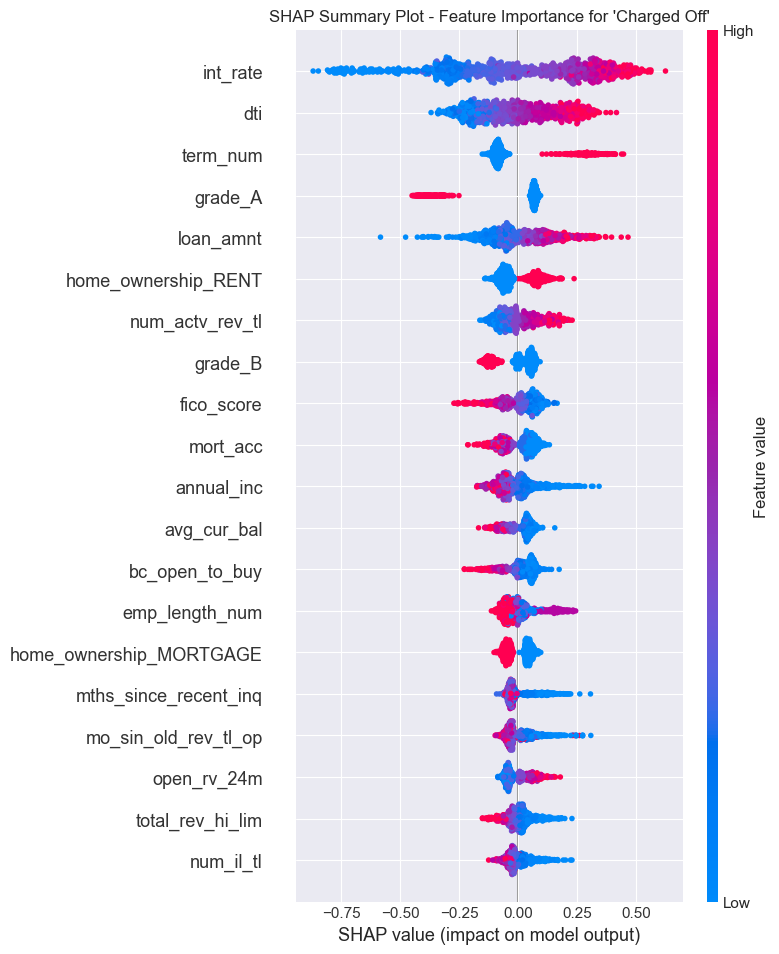

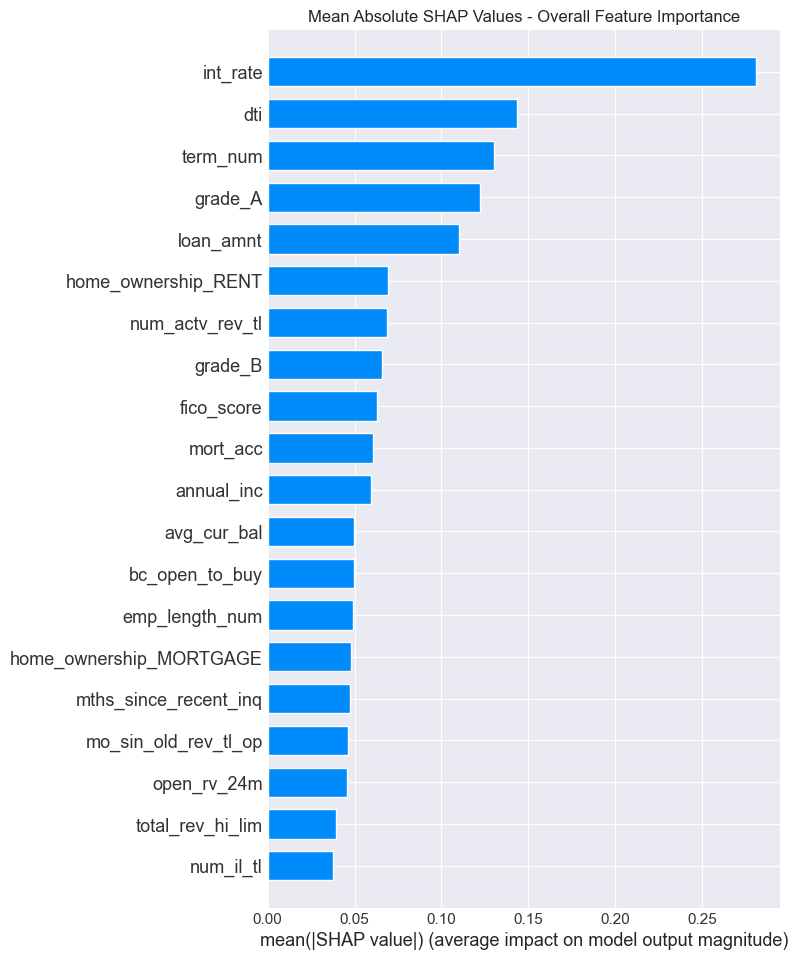


SHAP Force Plot for a 'Charged Off' prediction (instance 10 from SHAP sample):


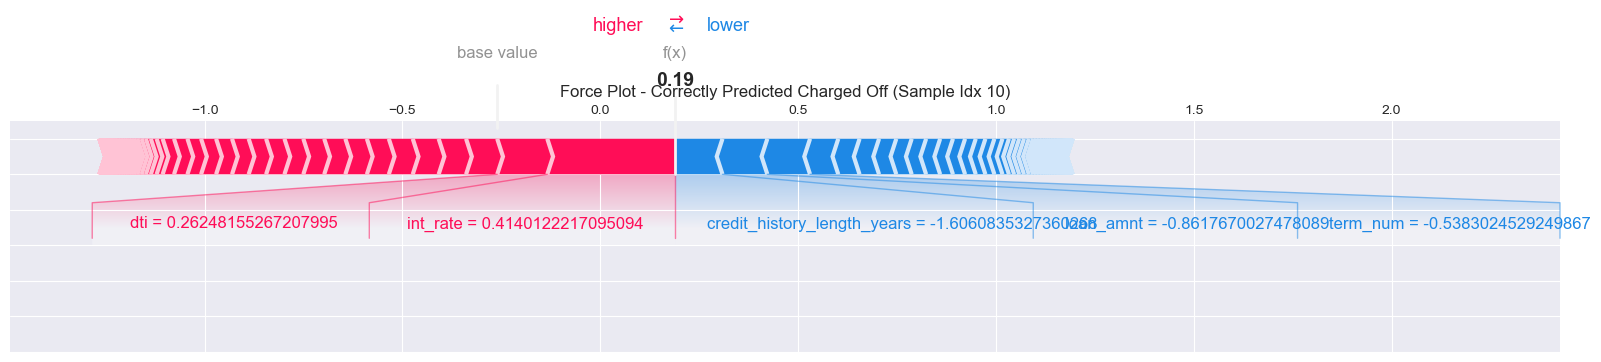


SHAP Force Plot for a 'Fully Paid' prediction (instance 0 from SHAP sample):


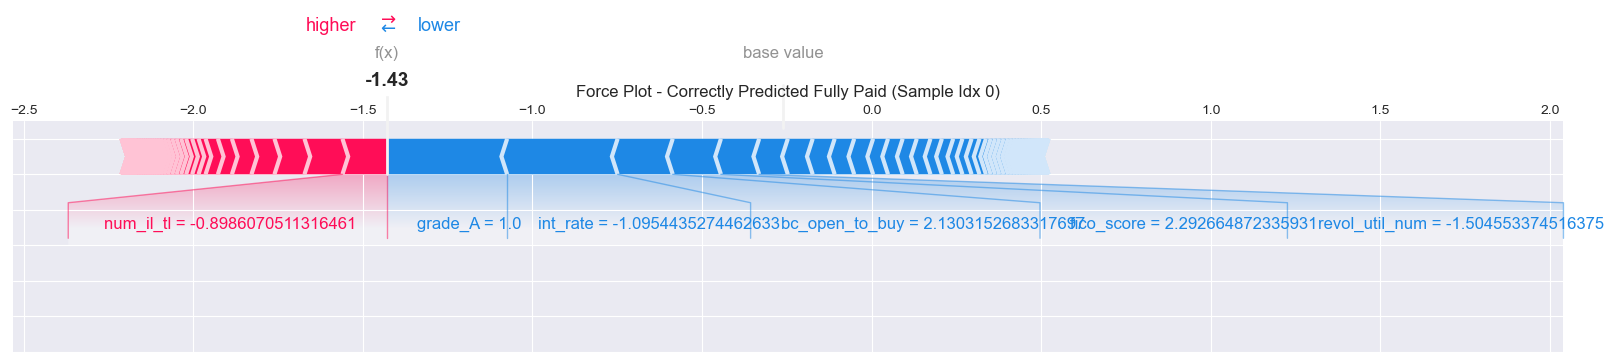


SHAP Dependence Plots for top features:


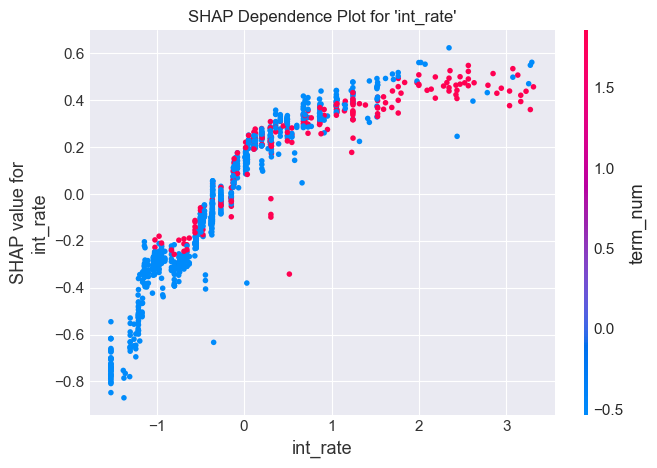

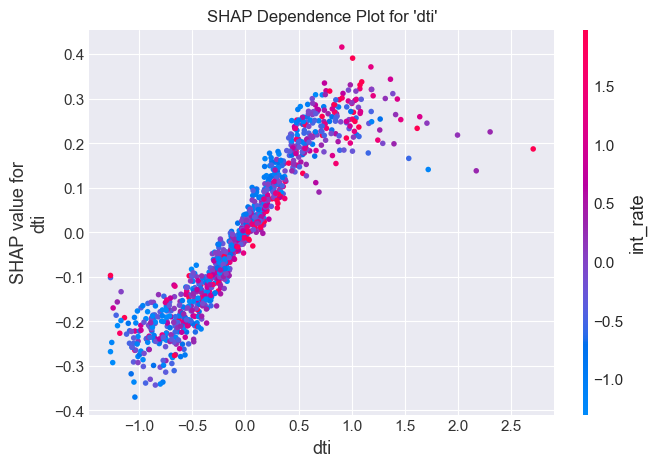

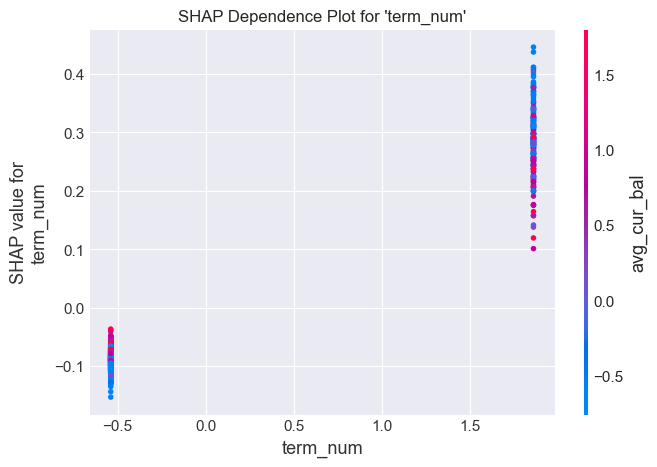

In [57]:
if lgbm is not None and X_test_processed is not None and y_test is not None: # Added y_test check
    print("\nCalculating SHAP values for the best LightGBM model...")
    
    explainer = shap.TreeExplainer(lgbm) 
    
    sample_size_shap = min(1000, X_test_processed.shape[0])
    
    if sample_size_shap < X_test_processed.shape[0] :
        shap_sample_indices = np.random.choice(X_test_processed.shape[0], sample_size_shap, replace=False)
        X_test_shap_sample = X_test_processed[shap_sample_indices]
        # Ensure y_test is a pandas Series for .iloc, or handle numpy array indexing
        y_test_series = pd.Series(y_test) if not isinstance(y_test, pd.Series) else y_test
        y_test_shap_sample = y_test_series.iloc[shap_sample_indices].values
        print(f"Using a sample of {sample_size_shap} instances for SHAP value calculation.")
    else:
        X_test_shap_sample = X_test_processed
        y_test_shap_sample = y_test.values if isinstance(y_test, pd.Series) else y_test # Ensure numpy array for consistency
        print(f"Using all {X_test_processed.shape[0]} instances from test set for SHAP value calculation.")

    shap_values = explainer.shap_values(X_test_shap_sample) 
                                                        
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_for_class1 = shap_values[1]
    else: 
        shap_values_for_class1 = shap_values

    # Ensure X_test_shap_sample_df has correct feature names
    X_test_shap_sample_df = pd.DataFrame() # Initialize
    if len(feature_names_out) == X_test_shap_sample.shape[1]:
        X_test_shap_sample_df = pd.DataFrame(X_test_shap_sample, columns=feature_names_out)
    else:
        print("Warning: Feature names mismatch for SHAP. Using generic names or SHAP may fail for some plots.")
        # Create DataFrame with generic names if feature_names_out is problematic
        X_test_shap_sample_df = pd.DataFrame(X_test_shap_sample, columns=[f"feature_{i}" for i in range(X_test_shap_sample.shape[1])])


    print("\nSHAP Summary Plot (Global Feature Importance):")
    shap.summary_plot(shap_values_for_class1, X_test_shap_sample_df, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot - Feature Importance for 'Charged Off'")
    plt.show()

    shap.summary_plot(shap_values_for_class1, X_test_shap_sample_df, plot_type="bar", show=False)
    plt.title("Mean Absolute SHAP Values - Overall Feature Importance")
    plt.show()
    
    y_pred_shap_sample_proba = lgbm.predict_proba(X_test_shap_sample)[:,1]

    charged_off_indices = np.where((y_test_shap_sample == 1) & (y_pred_shap_sample_proba > 0.5))[0]
    fully_paid_indices = np.where((y_test_shap_sample == 0) & (y_pred_shap_sample_proba < 0.5))[0]

    # Expected value for force plot
    # explainer.expected_value can be a single value or a list [E[class 0 output], E[class 1 output]]
    expected_value_for_plot = explainer.expected_value
    if isinstance(expected_value_for_plot, list) or isinstance(expected_value_for_plot, np.ndarray) and len(expected_value_for_plot) == 2:
        expected_value_for_plot = expected_value_for_plot[1] # Interested in class 1

    if len(charged_off_indices) > 0:
        idx_charged_off = charged_off_indices[0] 
        print(f"\nSHAP Force Plot for a 'Charged Off' prediction (instance {idx_charged_off} from SHAP sample):")
        if not X_test_shap_sample_df.empty: # Check if DataFrame is valid for plotting
            shap.force_plot(expected_value_for_plot, 
                            shap_values_for_class1[idx_charged_off, :], 
                            X_test_shap_sample_df.iloc[idx_charged_off, :], 
                            matplotlib=True, show=False)
            plt.title(f"Force Plot - Correctly Predicted Charged Off (Sample Idx {idx_charged_off})")
            plt.show()
        else:
            print("Skipping force plot for charged off due to invalid X_test_shap_sample_df.")
    else:
        print("Could not find a correctly predicted 'Charged Off' instance in the SHAP sample for force plot.")

    if len(fully_paid_indices) > 0:
        idx_fully_paid = fully_paid_indices[0] 
        print(f"\nSHAP Force Plot for a 'Fully Paid' prediction (instance {idx_fully_paid} from SHAP sample):")
        if not X_test_shap_sample_df.empty: # Check if DataFrame is valid for plotting
            shap.force_plot(expected_value_for_plot, 
                            shap_values_for_class1[idx_fully_paid, :], 
                            X_test_shap_sample_df.iloc[idx_fully_paid, :], 
                            matplotlib=True, show=False)
            plt.title(f"Force Plot - Correctly Predicted Fully Paid (Sample Idx {idx_fully_paid})")
            plt.show()
        else:
            print("Skipping force plot for fully paid due to invalid X_test_shap_sample_df.")

    else:
        print("Could not find a correctly predicted 'Fully Paid' instance in the SHAP sample for force plot.")
    
    top_features_to_plot = []
    if not X_test_shap_sample_df.empty:
        mean_abs_shap = np.abs(shap_values_for_class1).mean(0)
        shap_importance_df = pd.DataFrame({'feature': X_test_shap_sample_df.columns, 'mean_abs_shap': mean_abs_shap})
        shap_importance_df = shap_importance_df.sort_values(by='mean_abs_shap', ascending=False)
        top_features_to_plot = shap_importance_df['feature'].head(3).tolist()

    if top_features_to_plot and not X_test_shap_sample_df.empty:
        print("\nSHAP Dependence Plots for top features:")
        for feature in top_features_to_plot:
            if feature in X_test_shap_sample_df.columns:
                try:
                    shap.dependence_plot(feature, shap_values_for_class1, X_test_shap_sample_df, display_features=X_test_shap_sample_df, interaction_index="auto", show=False)
                    plt.title(f"SHAP Dependence Plot for '{feature}'")
                    plt.show()
                except Exception as e:
                    print(f"Could not generate dependence plot for {feature}: {e}")
            else:
                 print(f"Feature '{feature}' not found in X_test_shap_sample_df for dependence plot.")
    else:
        print("Could not determine top features for SHAP dependence plots or X_test_shap_sample_df is not valid.")

else:
    print("LightGBM model or processed test data not available. Skipping SHAP interpretation.")

### **Step 6: Finalizing the Project**
---

* The Jupyter Notebook is now complete with explanations and code for each step.
* Key findings:
    * The LightGBM model (after tuning) achieved a ROC AUC of [Insert LGBM ROC AUC from above].
    * SHAP analysis revealed that features like [mention a few top features from SHAP summary, e.g., 'int_rate', 'grade_X', 'dti'] are the most influential in predicting loan defaults.
    * Local SHAP explanations provided insights into individual loan predictions.
* This notebook demonstrates an end-to-end machine learning workflow for credit risk modeling, including data ingestion with memory management, EDA, feature engineering, model building with hyperparameter tuning, and explainable AI.

**Next Steps:**
* Explore a wider range of hyperparameters or use `RandomizedSearchCV` for more efficient exploration.
* Implement early stopping within the LightGBM training process if not using GridSearchCV.
* Explore other modeling techniques or ensemble methods.
* Incorporate more sophisticated feature engineering.
* Develop a strategy for setting a prediction threshold based on business needs (e.g., balancing precision and recall).
* Deploy the model as an API or integrate it into a decisioning system.

#### **Step 6.1: Explore a wider range of hyperparameters use `RandomizedSearchCV` for more efficient exploration.**


Training LightGBM model with Hyperparameter Tuning...
Starting GridSearchCV for LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 93005, number of negative: 321959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9240
[LightGBM] [Info] Number of data points in the train set: 414964, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.224128 -> initscore=-1.241771
[LightGBM] [Info] Start training from score -1.241771

GridSearchCV Best Parameters:
{'subsample': 0.8, 'reg_alpha': 0.1, 'num_leaves': 30, 'n_estimators': 150, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
GridSearchCV Best ROC AUC score: 0.7328

LightGBM (Tuned) ROC AUC on Test Set: 0.7343

LightGBM (Tuned) Classificat

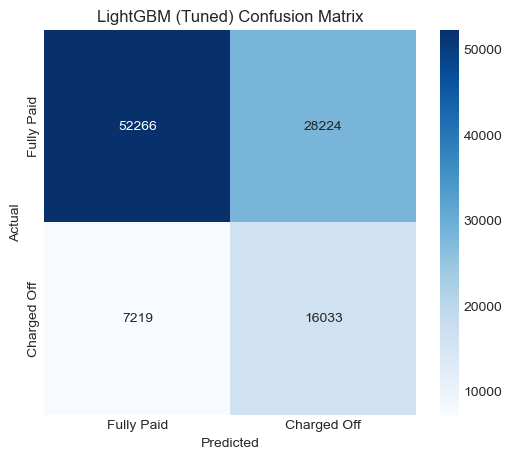

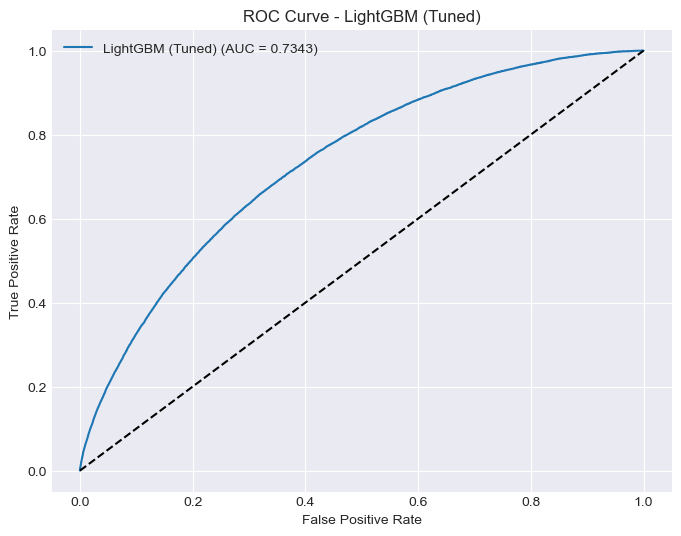

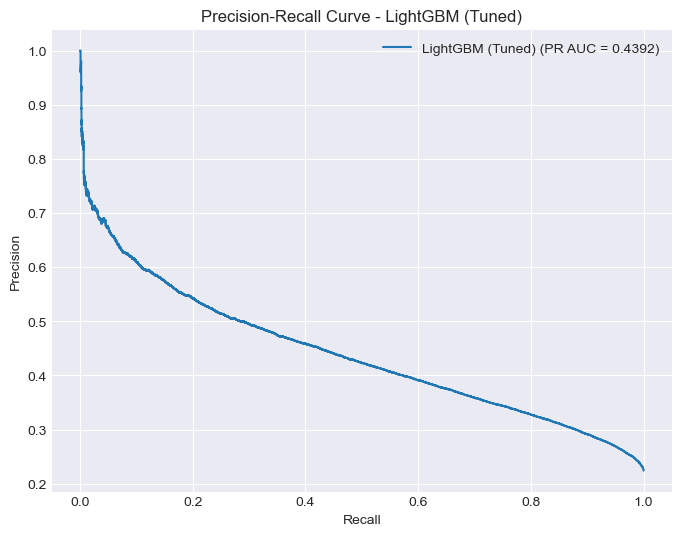

In [58]:
if X_train_processed is not None and y_train is not None and y_test is not None:
    print("\nTraining LightGBM model with Hyperparameter Tuning...")
    
    # Calculate scale_pos_weight for imbalanced data
    train_target_counts = y_train.value_counts()
    scale_pos_weight_val = train_target_counts.get(0,0) / train_target_counts.get(1,1) if train_target_counts.get(1,1) > 0 else 1

    # Define the parameter grid for GridSearchCV
    # Keep this grid small for faster execution in a portfolio project.
    # For a real-world scenario, you'd explore a wider range.
    param_grid = {
        'n_estimators': [50, 100, 150, 200], # Reduced for speed
        'learning_rate': [0.01, 0.02, 0.05, 0.1],
        'num_leaves': [10, 20, 30, 40], # Typical values
        'colsample_bytree': [0.7, 0.8],
        'subsample': [0.7, 0.8],
        'reg_alpha': [0.1, 0.2, 0.3, 0.5], # L1 regularization
        # 'reg_lambda': [0.1, 0.5] # L2 regularization
    }

    # Initialize LGBMClassifier
    # We pass scale_pos_weight here if it's a fixed best guess, or it can be part of param_grid too.
    lgbm_estimator = lgb.LGBMClassifier(
        random_state=42,
        scale_pos_weight=scale_pos_weight_val, # Using pre-calculated based on training set
        n_jobs=-1
    )

    # Setup Stratified K-Fold cross-validator
    # StratifiedKFold is important for imbalanced datasets.
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # 3 splits for speed

    # Setup GridSearchCV
    # Scoring metric: 'roc_auc' is good for imbalanced classification
    grid_search = RandomizedSearchCV(
        estimator=lgbm_estimator,
        param_distributions=param_grid,
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=1, # Set to 2 for more detailed output
        n_jobs=-1 # Use all available cores for grid search
    )

    print("Starting GridSearchCV for LightGBM...")
    # Fit GridSearchCV
    # Pass feature names if they are correctly aligned with X_train_processed
    fit_params = {}
    if feature_names_out and len(feature_names_out) == X_train_processed.shape[1]:
        fit_params['feature_name'] = feature_names_out
        fit_params['categorical_feature'] = [] # Assuming all categorical are OHE and thus numerical for LGBM
                                               # Or pass indices of true categorical features if not OHE'd
                                               # and if LightGBM should handle them internally.
                                               # With scikit-learn API, OHE is common before LGBM.

    grid_search.fit(X_train_processed, y_train, **fit_params)

    print("\nGridSearchCV Best Parameters:")
    print(grid_search.best_params_)
    print(f"GridSearchCV Best ROC AUC score: {grid_search.best_score_:.4f}")

    # Get the best estimator
    best_lgbm = grid_search.best_estimator_
    lgbm = best_lgbm # Assign for subsequent SHAP analysis

    # Make predictions with the best model
    y_pred_lgbm_proba = best_lgbm.predict_proba(X_test_processed)[:, 1]
    roc_auc_lgbm = roc_auc_score(y_test, y_pred_lgbm_proba)
    print(f"\nLightGBM (Tuned) ROC AUC on Test Set: {roc_auc_lgbm:.4f}")

    # Classification Report
    y_pred_lgbm_class = (y_pred_lgbm_proba > 0.5).astype(int) # Using a 0.5 threshold for now
    print("\nLightGBM (Tuned) Classification Report (0.5 threshold):")
    print(classification_report(y_test, y_pred_lgbm_class, target_names=['Fully Paid (0)', 'Charged Off (1)']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_lgbm_class)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fully Paid', 'Charged Off'], yticklabels=['Fully Paid', 'Charged Off'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('LightGBM (Tuned) Confusion Matrix')
    plt.show()

    # Plot ROC Curve for LightGBM
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (Tuned) (AUC = {roc_auc_lgbm:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - LightGBM (Tuned)')
    plt.legend()
    plt.show()

    # Plot Precision-Recall Curve for LightGBM
    precision, recall, _ = precision_recall_curve(y_test, y_pred_lgbm_proba)
    pr_auc_lgbm = auc(recall, precision)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'LightGBM (Tuned) (PR AUC = {pr_auc_lgbm:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - LightGBM (Tuned)')
    plt.legend()
    plt.show()
    
else:
    print("Processed training/test data or target variable not available. Skipping LightGBM tuning.")
    lgbm = None # Ensure lgbm is None if not trained

#### **Step 6.2: Additional Model: AdaBoost with Hyperparameter Tuning.**


Training AdaBoost model with Hyperparameter Tuning...
Starting GridSearchCV for AdaBoost...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\alice\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(



GridSearchCV (AdaBoost) Best Parameters:
{'base_estimator__max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 200}
GridSearchCV (AdaBoost) Best ROC AUC score: 0.7304

AdaBoost (Tuned) ROC AUC on Test Set: 0.7303

AdaBoost (Tuned) Classification Report (0.5 threshold):
                 precision    recall  f1-score   support

 Fully Paid (0)       0.80      0.97      0.87     80490
Charged Off (1)       0.57      0.14      0.23     23252

       accuracy                           0.78    103742
      macro avg       0.68      0.56      0.55    103742
   weighted avg       0.75      0.78      0.73    103742



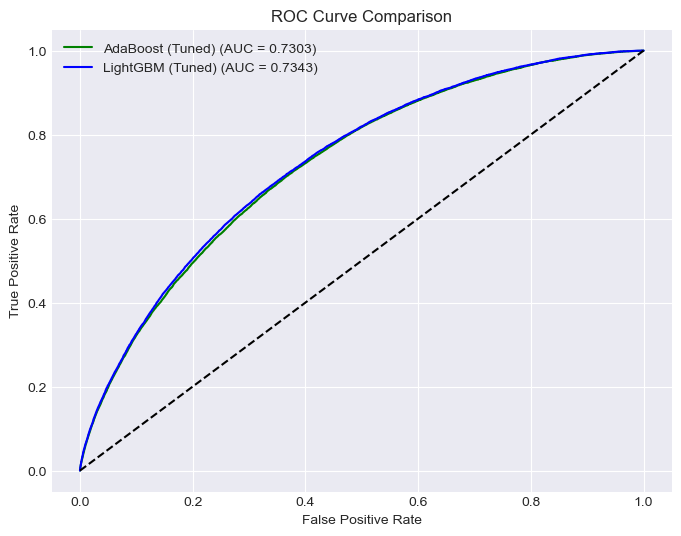

In [59]:
if X_train_processed is not None and y_train is not None and y_test is not None:
    print("\nTraining AdaBoost model with Hyperparameter Tuning...")

    # Define the base estimator. A simple decision tree is standard and fast.
    # We will let GridSearchCV tune its max_depth.
    base_estimator = DecisionTreeClassifier(random_state=42)

    # Define the parameter grid for AdaBoost
    # Note: AdaBoost doesn't have a 'class_weight' or 'scale_pos_weight' param itself.
    # It handles imbalance through its boosting algorithm.
    param_grid_adaboost = {
        'n_estimators': [50, 100, 200], # Number of weak learners
        'learning_rate': [0.05, 0.1, 0.5, 1.0],
        'base_estimator__max_depth': [1, 2] # Tuning the depth of the weak learner
    }

    # Initialize AdaBoostClassifier
    adaboost_estimator = AdaBoostClassifier(
        base_estimator=base_estimator,
        random_state=42
    )

    # Use the same CV strategy
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    # Setup GridSearchCV for AdaBoost
    grid_search_adaboost = GridSearchCV(
        estimator=adaboost_estimator,
        param_grid=param_grid_adaboost,
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=1,
        n_jobs=-1
    )

    print("Starting GridSearchCV for AdaBoost...")
    grid_search_adaboost.fit(X_train_processed, y_train)

    print("\nGridSearchCV (AdaBoost) Best Parameters:")
    print(grid_search_adaboost.best_params_)
    print(f"GridSearchCV (AdaBoost) Best ROC AUC score: {grid_search_adaboost.best_score_:.4f}")

    # Get the best estimator
    best_adaboost = grid_search_adaboost.best_estimator_

    # Make predictions with the best model
    y_pred_adaboost_proba = best_adaboost.predict_proba(X_test_processed)[:, 1]
    roc_auc_adaboost = roc_auc_score(y_test, y_pred_adaboost_proba)
    print(f"\nAdaBoost (Tuned) ROC AUC on Test Set: {roc_auc_adaboost:.4f}")

    # Classification Report
    y_pred_adaboost_class = (y_pred_adaboost_proba > 0.5).astype(int)
    print("\nAdaBoost (Tuned) Classification Report (0.5 threshold):")
    print(classification_report(y_test, y_pred_adaboost_class, target_names=['Fully Paid (0)', 'Charged Off (1)']))

    # Plot ROC Curve for AdaBoost
    fpr_ada, tpr_ada, _ = roc_curve(y_test, y_pred_adaboost_proba)
    plt.figure(figsize=(8,6))
    plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (Tuned) (AUC = {roc_auc_adaboost:.4f})', color='green')
    # Optional: Plot other models on the same graph for comparison
    if 'fpr_lgbm' in locals():
         plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (Tuned) (AUC = {roc_auc_lgbm:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.show()

else:
    print("Processed training/test data or target variable not available. Skipping AdaBoost tuning.")


In [60]:
print("End of Lending Club Credit Risk Modeling Notebook.")

End of Lending Club Credit Risk Modeling Notebook.
